In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
power_stations = pd.read_csv('../data/power_stations_clean.csv', delimiter=';', encoding='latin1')
Consumption2020_2024 = pd.read_csv('../data/Actual_consumption_202001010000_202405250100_Quarterhour.csv',na_values='-', sep=';', encoding='latin1', thousands=',')
Consumption2015_2020 = pd.read_csv('../data/Actual_consumption_201501010000_202001020100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',')
Generation_2020_2024 = pd.read_csv('../data/Actual_generation_202001010000_202405250100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',') 
Generation_2015_2020 = pd.read_csv('../data/Actual_generation_201501010000_202001020100_Quarterhour.csv',na_values='-', sep=';', encoding='latin1',thousands=',') 
Cross_Border_2020_2024 = pd.read_csv('../data/Cross-border_physical_flows_202001010000_202405250100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',') 
Cross_Border_2015_2020 = pd.read_csv('../data/Cross-border_physical_flows_201501010000_202001020100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',') 
Prices_2015_2020 = pd.read_csv('../data/Day-ahead_prices_201501010000_202001020100_Quarterhour.csv', delimiter=';',na_values='-', encoding='utf-8',thousands=',') 
Prices_2020_2024 = pd.read_csv('../data/Day-ahead_prices_202001010000_202405250100_Quarterhour.csv', delimiter=';',na_values='-', encoding='utf-8',thousands=',') 

### Generation_2020_2024

In [3]:
Generation_2020_2024['Start date'] = pd.to_datetime(Generation_2020_2024['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Generation_2020_2024['End date'] = pd.to_datetime(Generation_2020_2024['End date'], format='%b %d, %Y %I:%M %p')
Generation_2020_2024= Generation_2020_2024.drop('ï»¿Start date', axis=1)
Generation_2020_2024 = Generation_2020_2024[['Start date',
 'End date',
 'Biomass [MWh] Original resolutions',
 'Hydropower [MWh] Original resolutions',
 'Wind offshore [MWh] Original resolutions',
 'Wind onshore [MWh] Original resolutions',
 'Photovoltaics [MWh] Original resolutions',
 'Other renewable [MWh] Original resolutions',
 'Nuclear [MWh] Original resolutions',
 'Lignite [MWh] Original resolutions',
 'Hard coal [MWh] Original resolutions',
 'Fossil gas [MWh] Original resolutions',
 'Hydro pumped storage [MWh] Original resolutions',
 'Other conventional [MWh] Original resolutions']]


### Generation_2015_2020

In [4]:
Generation_2015_2020['Start date'] = pd.to_datetime(Generation_2015_2020['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Generation_2015_2020['End date'] = pd.to_datetime(Generation_2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Generation_2015_2020= Generation_2015_2020.drop('ï»¿Start date', axis=1)
Generation_2015_2020 = Generation_2015_2020[['Start date',
 'End date',
 'Biomass [MWh] Original resolutions',
 'Hydropower [MWh] Original resolutions',
 'Wind offshore [MWh] Original resolutions',
 'Wind onshore [MWh] Original resolutions',
 'Photovoltaics [MWh] Original resolutions',
 'Other renewable [MWh] Original resolutions',
 'Nuclear [MWh] Original resolutions',
 'Lignite [MWh] Original resolutions',
 'Hard coal [MWh] Original resolutions',
 'Fossil gas [MWh] Original resolutions',
 'Hydro pumped storage [MWh] Original resolutions',
 'Other conventional [MWh] Original resolutions']]
Generation_2015_2020 = Generation_2015_2020[Generation_2015_2020['End date'] <= '2020-01-01 00:00:00']

### Consumption2015_2020


In [5]:
Consumption2015_2020['Start date'] = pd.to_datetime(Consumption2015_2020['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Consumption2015_2020['End date'] = pd.to_datetime(Consumption2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Consumption2015_2020= Consumption2015_2020.drop('ï»¿Start date', axis=1)
Consumption2015_2020 = Consumption2015_2020[Consumption2015_2020['End date'] <= '2020-01-01 00:00:00']

### Consumption2024_2024

In [6]:
Consumption2020_2024['Start date'] = pd.to_datetime(Consumption2020_2024['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Consumption2020_2024['End date'] = pd.to_datetime(Consumption2020_2024['End date'], format='%b %d, %Y %I:%M %p')
Consumption2020_2024= Consumption2020_2024.drop('ï»¿Start date', axis=1)

### Cross_Boader_2020_2024

In [7]:
Cross_Border_2020_2024['Start date'] = pd.to_datetime(Cross_Border_2020_2024['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2020_2024['End date'] = pd.to_datetime(Cross_Border_2020_2024['End date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2020_2024= Cross_Border_2020_2024.drop('ï»¿Start date', axis=1)


### Cross_Boader_2015_2020

In [8]:
Cross_Border_2015_2020['Start date'] = pd.to_datetime(Cross_Border_2015_2020['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2015_2020['End date'] = pd.to_datetime(Cross_Border_2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2015_2020= Cross_Border_2015_2020.drop('ï»¿Start date', axis=1)
Cross_Border_2015_2020 = Cross_Border_2015_2020[Cross_Border_2015_2020['End date'] <= '2020-01-01 00:00:00']

### Prices_2015_2020

In [9]:
Prices_2015_2020['Start date'] = pd.to_datetime(Prices_2015_2020['Start date'], format='%b %d, %Y %I:%M %p')
Prices_2015_2020['End date'] = pd.to_datetime(Prices_2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Prices_2015_2020 = Prices_2015_2020[Prices_2015_2020['End date'] <= '2020-01-01 00:00:00']

### Prices_2020_2024

In [10]:
Prices_2020_2024['Start date'] = pd.to_datetime(Prices_2020_2024['Start date'], format='%b %d, %Y %I:%M %p')
Prices_2020_2024['End date'] = pd.to_datetime(Prices_2020_2024['End date'], format='%b %d, %Y %I:%M %p')


#### Concat all to big DataFrames 

In [11]:
Prices = pd.concat([Prices_2015_2020, Prices_2020_2024])
Cross_Border = pd.concat([Cross_Border_2015_2020, Cross_Border_2020_2024])
Consumption = pd.concat([Consumption2015_2020, Consumption2020_2024])
Generation = pd.concat([Generation_2015_2020, Generation_2020_2024])



In [12]:
Prices = Prices.reset_index(drop=True)
Cross_Border = Cross_Border.reset_index(drop=True)
Consumption = Consumption.reset_index(drop=True)
Generation = Generation.reset_index(drop=True)

Weil es zwischen den 2015-2020 und 2020-2024 Überschneidungen gibt

In [13]:
Consumption.drop(index= range(329440, 329472), inplace= True)
Cross_Border.drop(index= range(329440, 329472), inplace= True)
Generation.drop(index= range(329440, 329472), inplace= True)
Prices.drop(index= range(329440, 329472), inplace= True)

In [14]:
# Add sum columns
Cross_Border['Sum [MWh]'] = Cross_Border.loc[:, Cross_Border.columns.difference(['Start date', 'End date','Net export [MWh] Original resolutions'])].sum(axis = 1)
Generation['Sum [MWh]'] = Generation.loc[:, Generation.columns.difference(['Start date', 'End date'])].sum(axis = 1)

In [15]:
# Order the columns

Consumption = Consumption[['Start date','End date',
 'Total (grid load) [MWh] Original resolutions',
 'Residual load [MWh] Original resolutions',
 'Hydro pumped storage [MWh] Original resolutions'
 ]]

In [16]:
Cross_Border = Cross_Border[['Start date','End date',
 'Net export [MWh] Original resolutions',
 'Netherlands (export) [MWh] Original resolutions',
 'Netherlands (import) [MWh] Original resolutions',
 'Switzerland (export) [MWh] Original resolutions',
 'Switzerland (import) [MWh] Original resolutions',
 'Denmark (export) [MWh] Original resolutions',
 'Denmark (import) [MWh] Original resolutions',
 'Czech Republic (export) [MWh] Original resolutions',
 'Czech Republic (import) [MWh] Original resolutions',
 'Luxembourg (export) [MWh] Original resolutions',
 'Luxembourg (import) [MWh] Original resolutions',
 'Sweden (export) [MWh] Original resolutions',
 'Sweden (import) [MWh] Original resolutions',
 'Austria (export) [MWh] Original resolutions',
 'Austria (import) [MWh] Original resolutions',
 'France (export) [MWh] Original resolutions',
 'France (import) [MWh] Original resolutions',
 'Poland (export) [MWh] Original resolutions',
 'Poland (import) [MWh] Original resolutions',
 'Norway (export) [MWh] Original resolutions',
 'Norway (import) [MWh] Original resolutions',
 'Belgium (export) [MWh] Original resolutions',
 'Belgium (import) [MWh] Original resolutions',
 'Sum [MWh]']]

In [17]:
Generation = Generation.drop(Generation.loc[Generation['Start date'].duplicated(keep='first')].index, axis=0)
Consumption = Consumption.drop(Consumption.loc[Consumption['Start date'].duplicated(keep='first')].index, axis=0)
Prices = Prices.drop(Prices.loc[Prices['Start date'].duplicated(keep='first')].index, axis=0)
Cross_Border = Cross_Border.drop(Cross_Border.loc[Cross_Border['Start date'].duplicated(keep='first')].index, axis=0)

### Set the index to the start date 

In [18]:
Consumption = Consumption.set_index('Start date')
Generation = Generation.set_index('Start date')
Cross_Border = Cross_Border.set_index('Start date')
Prices = Prices.set_index('Start date')

### Check for missing dates in the dataset

In [19]:
first_day_con = Consumption.index.min()
last_day_con = Consumption.index.max()
first_day_pri = Prices.index.min()
last_day_pri = Prices.index.max()
first_day_gen = Generation.index.min()
last_day_gen = Generation.index.max()
first_day_cro = Cross_Border.index.min()
last_day_cro = Cross_Border.index.max()

In [20]:
full_range_con = pd.date_range(start=first_day_con, end=last_day_con, freq="15min")
full_range_pri = pd.date_range(start=first_day_pri, end=last_day_pri, freq="15min")
full_range_gen = pd.date_range(start=first_day_gen, end=last_day_gen, freq="15min")
full_range_cro = pd.date_range(start=first_day_cro, end=last_day_cro, freq="15min")

In [21]:
print(full_range_con.shape)
print(full_range_pri.shape)
print(full_range_gen.shape)
print(full_range_cro.shape)

(329444,)
(329444,)
(329444,)
(329444,)


### Data cleaning Generation

Get an overview

In [22]:
Generation.isna().sum()

End date                                               0
Biomass [MWh] Original resolutions                     0
Hydropower [MWh] Original resolutions                  0
Wind offshore [MWh] Original resolutions               0
Wind onshore [MWh] Original resolutions                1
Photovoltaics [MWh] Original resolutions               0
Other renewable [MWh] Original resolutions             0
Nuclear [MWh] Original resolutions                 11054
Lignite [MWh] Original resolutions                     0
Hard coal [MWh] Original resolutions                   0
Fossil gas [MWh] Original resolutions                  0
Hydro pumped storage [MWh] Original resolutions        1
Other conventional [MWh] Original resolutions          1
Sum [MWh]                                              0
dtype: int64

In [23]:
missing_dates_Generation = full_range_gen.difference(Generation.index)
print(len(missing_dates_Generation))

40


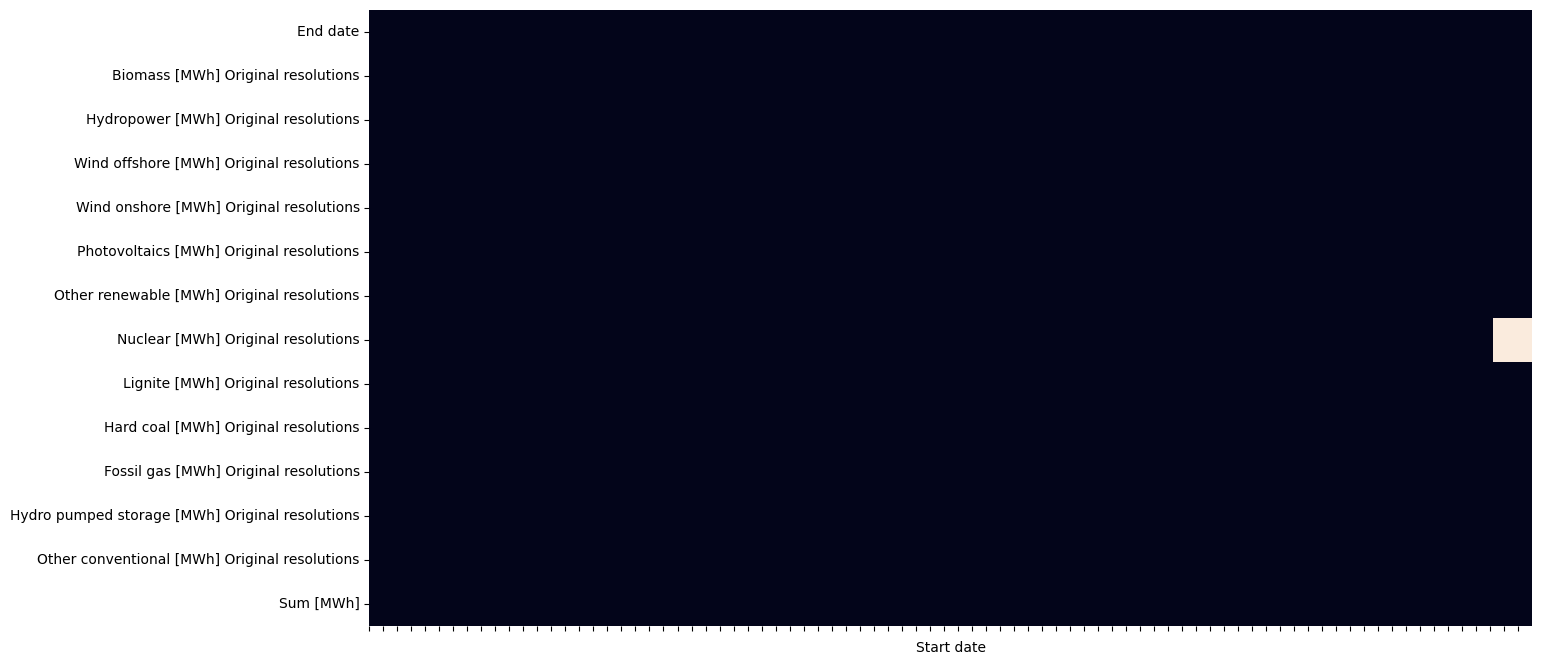

In [24]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(Generation.isna().T,cbar=False)
ax.set(xticklabels=[])

plt.show()

Nuclear power was shut down in Germany at midnight on 15 April 2023. Nuclear energy was marked as null in the data because it was not clear whether the coalition would decide to reopen the power plants due to the energy crisis in Europe caused by the Russia-Ukraine war. On 30 January 2024, nuclear energy was removed as an energy source from the data and all values are NaN. Therefore the NaN values are replaced by 0.

In [25]:
Generation['Nuclear [MWh] Original resolutions'] = Generation['Nuclear [MWh] Original resolutions'].fillna(0)

In [26]:
d = pd.to_datetime(['2023-04-15 23:30','2023-04-15 23:45', '2023-04-16 00:00','2023-04-16 00:15'])

Generation[Generation.index.isin(d)][['Nuclear [MWh] Original resolutions']]


,Nuclear [MWh] Original resolutions
Start date,
2023-04-15 23:30:00,28.75
2023-04-15 23:45:00,12.75
2023-04-16 00:00:00,0.00
2023-04-16 00:15:00,0.00


In [27]:
Generation[Generation[['Wind onshore [MWh] Original resolutions','Hydro pumped storage [MWh] Original resolutions','Other conventional [MWh] Original resolutions']].isna().any(axis =1)]

,End date,Biomass [MWh] Original resolutions,Hydropower [MWh] Original resolutions,Wind offshore [MWh] Original resolutions,Wind onshore [MWh] Original resolutions,Photovoltaics [MWh] Original resolutions,Other renewable [MWh] Original resolutions,Nuclear [MWh] Original resolutions,Lignite [MWh] Original resolutions,Hard coal [MWh] Original resolutions,Fossil gas [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions,Other conventional [MWh] Original resolutions,Sum [MWh]
Start date,,,,,,,,,,,,,,
2024-03-25 15:00:00,2024-03-25 15:15:00,1086.00,420.25,36.75,982.5,6599.0,21.0,0.0,2079.25,590.25,1283.50,15.0,NaN,13113.50
2024-05-24 11:15:00,2024-05-24 11:30:00,1102.75,256.00,6.00,NaN,6827.0,28.0,0.0,2179.75,554.75,1180.75,NaN,195.75,12330.75


the other missing values can only be found in two columns. These are interpolated

In [28]:
Generation = Generation.reindex(full_range_gen)

In [29]:
missing_dates_Generation = full_range_gen.difference(Generation.index)
print(len(missing_dates_Generation))

0


In [30]:
Generation.isna().sum()

End date                                           40
Biomass [MWh] Original resolutions                 40
Hydropower [MWh] Original resolutions              40
Wind offshore [MWh] Original resolutions           40
Wind onshore [MWh] Original resolutions            41
Photovoltaics [MWh] Original resolutions           40
Other renewable [MWh] Original resolutions         40
Nuclear [MWh] Original resolutions                 40
Lignite [MWh] Original resolutions                 40
Hard coal [MWh] Original resolutions               40
Fossil gas [MWh] Original resolutions              40
Hydro pumped storage [MWh] Original resolutions    41
Other conventional [MWh] Original resolutions      41
Sum [MWh]                                          40
dtype: int64

In [31]:
Generation = Generation.interpolate()

In [32]:
Generation.isna().sum().sum()

0

### Data Cleaning Consumption

In [33]:
Consumption.isna().sum()

End date                                           0
Total (grid load) [MWh] Original resolutions       0
Residual load [MWh] Original resolutions           4
Hydro pumped storage [MWh] Original resolutions    1
dtype: int64

In [34]:
missing_dates_Consumption = full_range_con.difference(Consumption.index)
print(len(missing_dates_Consumption))

40


In [35]:
Consumption[Consumption[['Residual load [MWh] Original resolutions','Hydro pumped storage [MWh] Original resolutions']].isna().any(axis =1)]

,End date,Total (grid load) [MWh] Original resolutions,Residual load [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions
Start date,,,,
2021-01-06 08:15:00,2021-01-06 08:30:00,15737.75,NaN,61.00
2021-01-06 15:45:00,2021-01-06 16:00:00,16119.00,NaN,3.75
2021-01-06 17:00:00,2021-01-06 17:15:00,16773.00,NaN,1.00
2024-05-24 11:15:00,2024-05-24 11:30:00,13630.00,NaN,NaN


In [36]:
Consumption = Consumption.reindex(full_range_con)

In [37]:
Consumption.isna().sum()

End date                                           40
Total (grid load) [MWh] Original resolutions       40
Residual load [MWh] Original resolutions           44
Hydro pumped storage [MWh] Original resolutions    41
dtype: int64

In [38]:
Consumption = Consumption.interpolate()

In [39]:
Consumption.isna().sum().sum()

0

In [40]:
# plt.figure(figsize=(15,8))

# ax = sns.heatmap(Consumption.isna().T,cbar=False)
# ax.set(xticklabels=[])
# plt.show()

The dataset is complete. Hydro pumped storage and residual load are part of the total grid load.  

#### Cross_Border

In [41]:
missing_dates_Cross_Border = full_range_cro.difference(Cross_Border.index)
print(len(missing_dates_Cross_Border))

40


In [42]:
Cross_Border.isna().sum()

End date                                                   0
Net export [MWh] Original resolutions                 203196
Netherlands (export) [MWh] Original resolutions         2258
Netherlands (import) [MWh] Original resolutions         2258
Switzerland (export) [MWh] Original resolutions         5171
Switzerland (import) [MWh] Original resolutions         5171
Denmark (export) [MWh] Original resolutions              524
Denmark (import) [MWh] Original resolutions              524
Czech Republic (export) [MWh] Original resolutions         0
Czech Republic (import) [MWh] Original resolutions         0
Luxembourg (export) [MWh] Original resolutions         89387
Luxembourg (import) [MWh] Original resolutions         89387
Sweden (export) [MWh] Original resolutions                 0
Sweden (import) [MWh] Original resolutions                 0
Austria (export) [MWh] Original resolutions                6
Austria (import) [MWh] Original resolutions                6
France (export) [MWh] Or

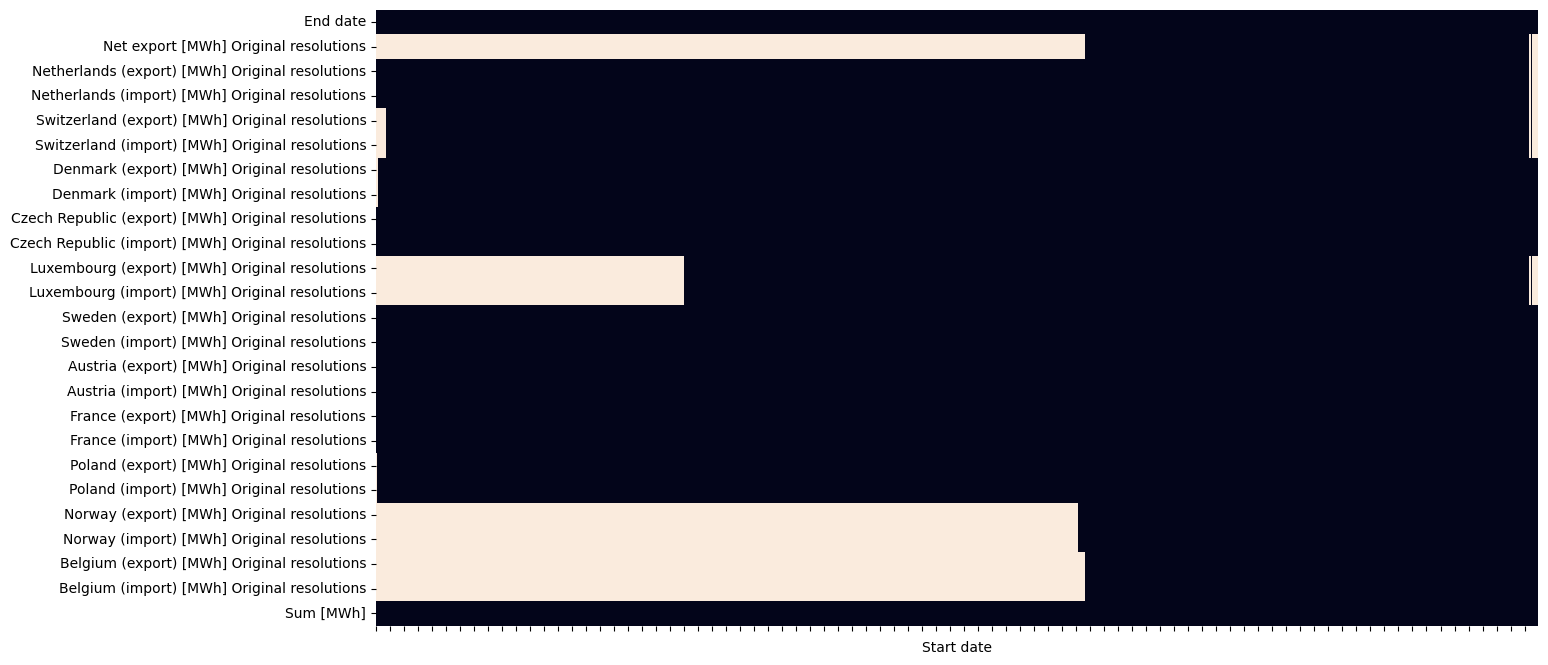

In [43]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(Cross_Border.isna().T,cbar=False)
ax.set(xticklabels=[])

plt.show()

Net Export seems to generate NaN values if the other columns have NaN values. The physical current flow is important for the balance of demand and supply. For this reason, a sum column has already been inserted, which replaces net export and is equivalent if net export has a value. All other values are replaced with 0. net export is removed. 

In [44]:
Cross_Border = Cross_Border.drop('Net export [MWh] Original resolutions', axis =1 )

In [45]:
Cross_Border = Cross_Border.fillna(0)

In [46]:
Cross_Border = Cross_Border.reindex(full_range_cro)

In [47]:
Cross_Border = Cross_Border.interpolate()

In [48]:
Cross_Border.isna().sum().sum()

0

#### Prices

In [49]:

missing_dates_Prices = full_range_pri.difference(Prices.index)
print(len(missing_dates_Prices))


40


In [50]:
Prices['Germany/Luxembourg [€/MWh] Calculated resolutions'].isna().sum()

131408

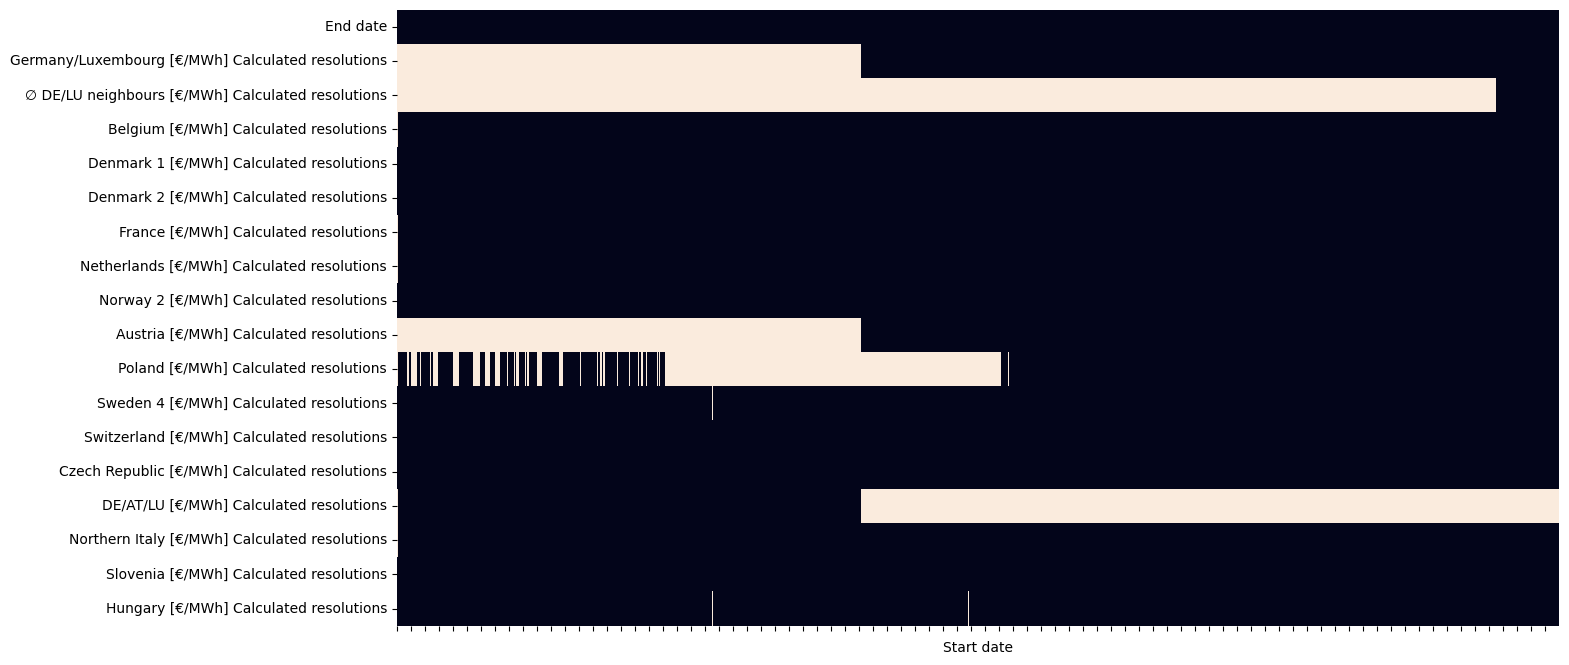

In [51]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(Prices.isna().T,cbar=False)
ax.set(xticklabels=[])
plt.show()

With Prices is less clear. Therefore, the matter is considered in detail below

In [52]:
def list_to_dictionary(list):
    '''
    Example: 
    meine_liste = ['Apfel', 'Banane', 'Kirsche']
    mein_dictionary = liste_zu_dictionary(meine_liste)
    {
        0:Apfel,
        1:Banane,
        3:Kirsche
    }
    '''
    return {index: x for index, x in enumerate(list)}


We start with Prices 

In [53]:
columns = list_to_dictionary(list(Prices.columns)[2:]) # without Start date and End date 

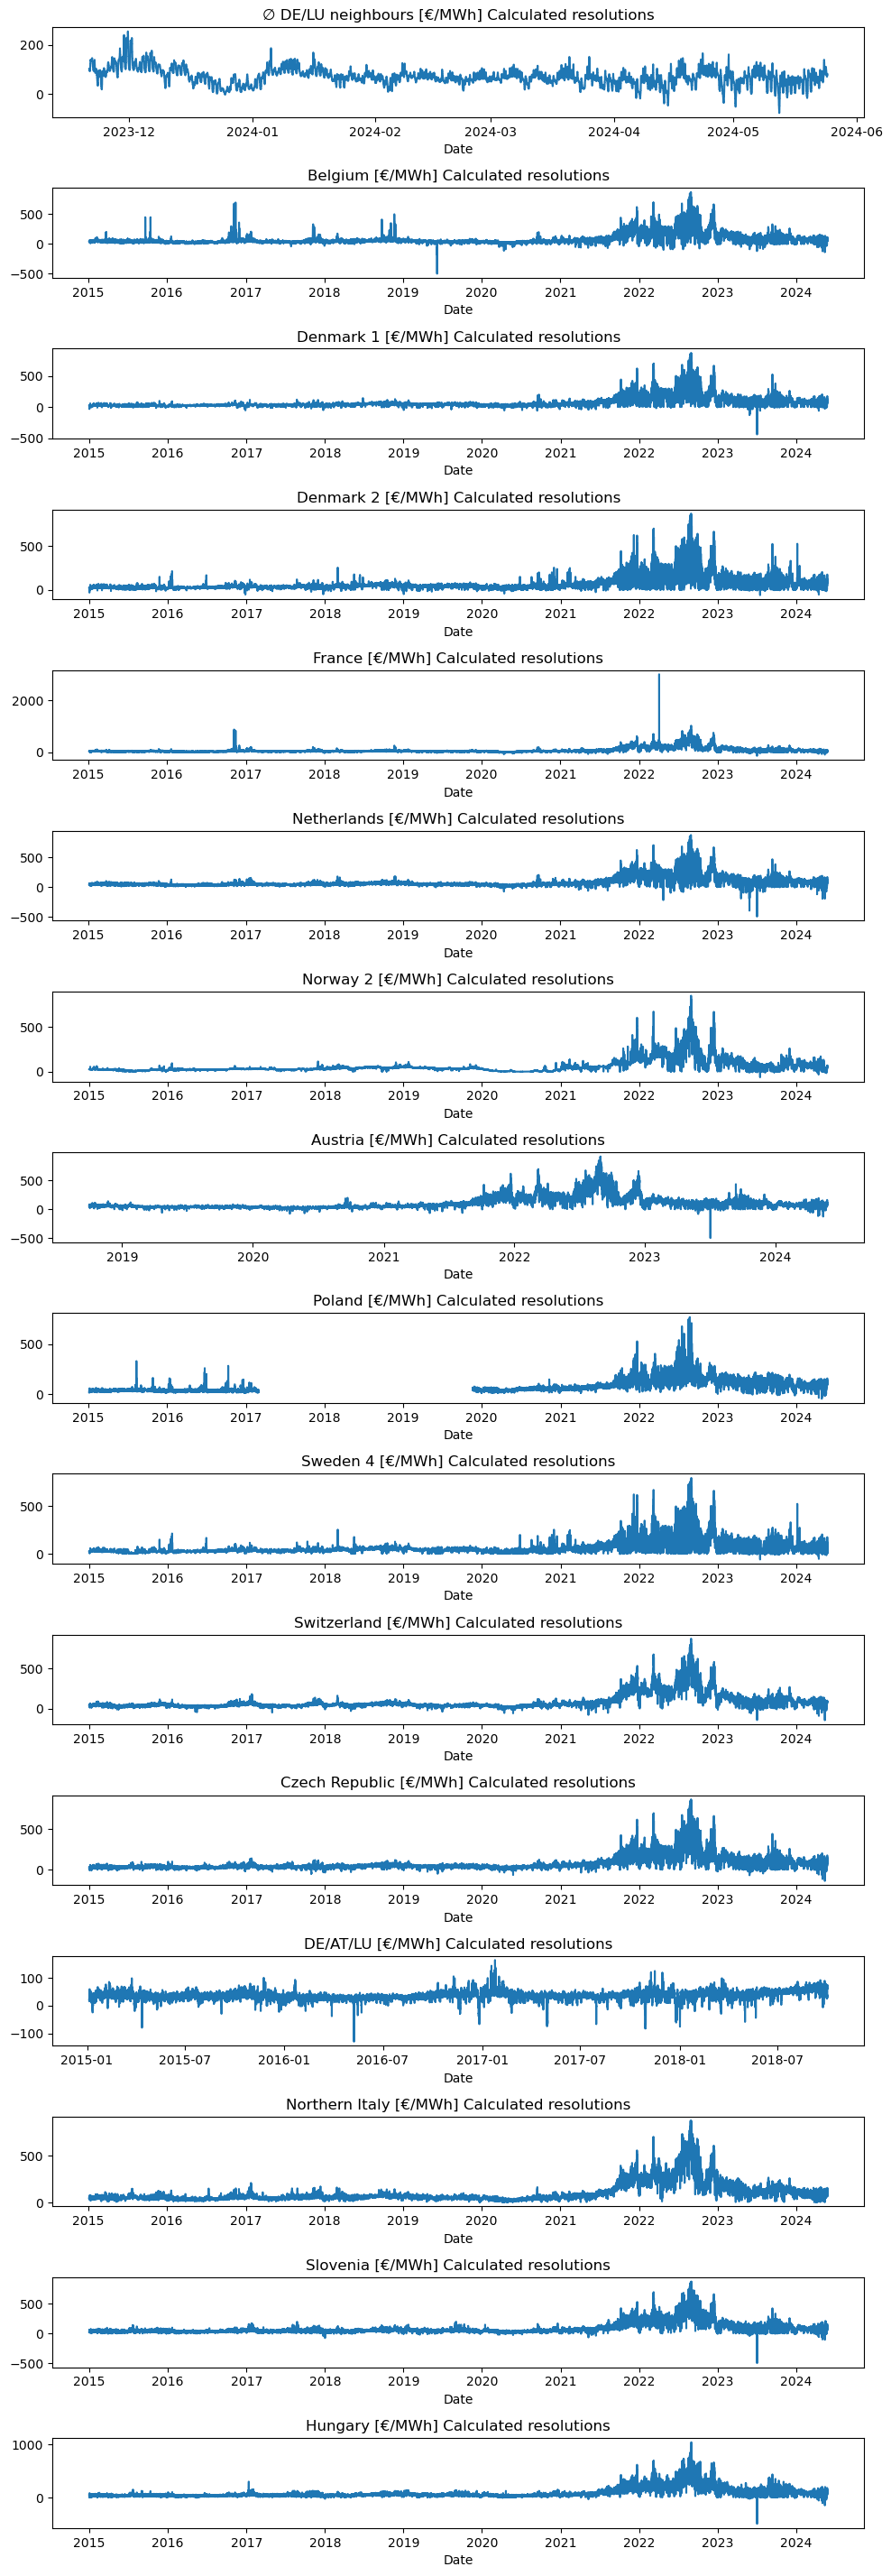

In [54]:
fig = plt.figure(figsize=(10, 30))  # Adjust figure size accordingly
gs = gridspec.GridSpec(17, 1, height_ratios=[1]*17)  # Adjust height_ratios as needed

for k, c in columns.items():
    ax = fig.add_subplot(gs[k])
    ax.plot(Prices.index, Prices[c])
    ax.set_title(c)
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Germany, Luxembourg and Austria initially form a price zone in the data set. This ends and then splits into the Germany/Luxembourg and Austria zones.

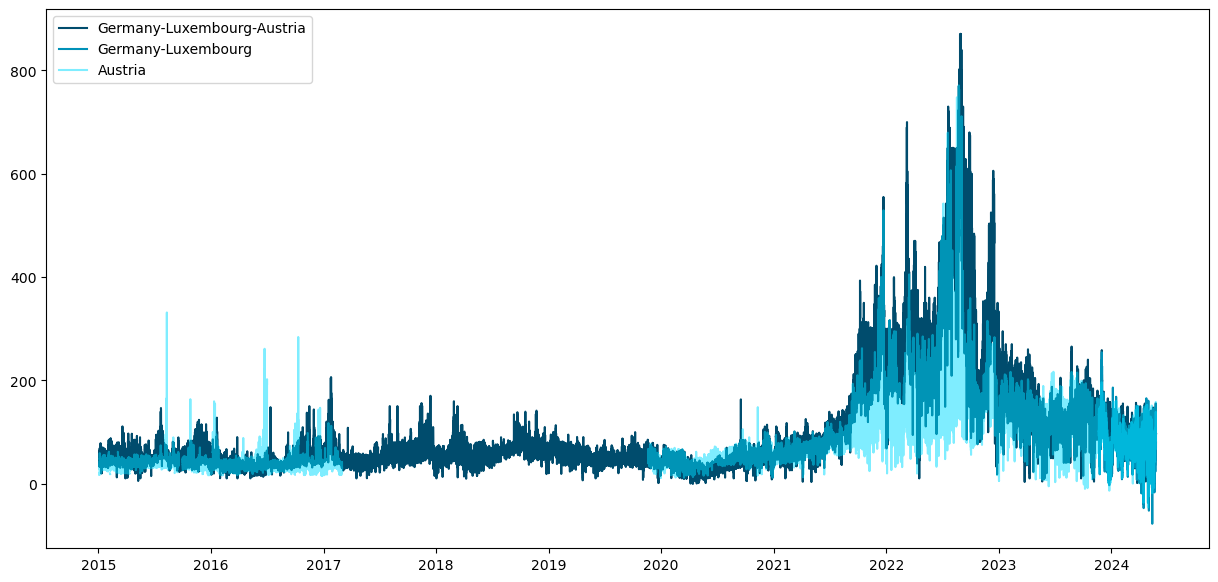

In [55]:
plt.figure(figsize=(15,7))
plt.plot(Prices.index, Prices[columns[13]],color = '#004c6d',label = "Germany-Luxembourg-Austria")
plt.plot(Prices.index, Prices[columns[0]], color ='#0091b8' , label = "Germany-Luxembourg")
plt.plot(Prices.index, Prices[columns[8]], color = '#00ddff', alpha = 0.5,label = "Austria")

plt.legend()
plt.show()

The columns complement each other. The split between Germany and Luxembourg on the one side and Austria on the other took place on 30 September 2018. The columns are therefore merged.

In [56]:
Prices['Germany/Luxembourg [€/MWh] Calculated resolutions'] = Prices['Germany/Luxembourg [€/MWh] Calculated resolutions'].fillna(0)+Prices['DE/AT/LU [€/MWh] Calculated resolutions'].fillna(0)
Prices['Austria [€/MWh] Calculated resolutions'] = Prices['Austria [€/MWh] Calculated resolutions'].fillna(0)+Prices['DE/AT/LU [€/MWh] Calculated resolutions'].fillna(0)

In [57]:
#drop the old column DE/AT/LU [€/MWh]
Prices = Prices.drop('DE/AT/LU [€/MWh] Calculated resolutions', axis = 1)

the missing values for Sweden 4 [€/MWh] and Hungary [€/MWh] are replaced by interpolation.

In [58]:
Prices['Hungary [€/MWh] Calculated resolutions'] = Prices['Hungary [€/MWh] Calculated resolutions'].interpolate(method='linear')

In [59]:
Prices['Sweden 4 [€/MWh] Calculated resolutions'] = Prices['Sweden 4 [€/MWh] Calculated resolutions'].interpolate(method='linear')

The column DU/LU neighbours is removed as a column, it is an average.

In [60]:
Prices = Prices.drop('∅ DE/LU neighbours [€/MWh] Calculated resolutions', axis = 1)

In [61]:
Prices = Prices.reindex(full_range_pri)

In [62]:
Prices.isna().sum()

End date                                                 40
Germany/Luxembourg [€/MWh] Calculated resolutions        40
Belgium [€/MWh] Calculated resolutions                  424
Denmark 1 [€/MWh] Calculated resolutions                 40
Denmark 2 [€/MWh] Calculated resolutions                 40
France [€/MWh] Calculated resolutions                   520
Netherlands [€/MWh] Calculated resolutions              424
Norway 2 [€/MWh] Calculated resolutions                  40
Austria [€/MWh] Calculated resolutions                   40
Poland [€/MWh] Calculated resolutions                114068
Sweden 4 [€/MWh] Calculated resolutions                  40
Switzerland [€/MWh] Calculated resolutions              136
Czech Republic [€/MWh] Calculated resolutions            40
Northern Italy [€/MWh] Calculated resolutions           424
Slovenia [€/MWh] Calculated resolutions                  40
Hungary [€/MWh] Calculated resolutions                   40
dtype: int64

to ensure that all border values are filled.

In [63]:
columns_to_fill = Prices.columns.difference(['Poland [€/MWh] Calculated resolutions'])

In [64]:
Prices[columns_to_fill] = Prices[columns_to_fill].interpolate().fillna(method='ffill').fillna(method='bfill')

In [65]:
Prices.isna().sum()

End date                                                  0
Germany/Luxembourg [€/MWh] Calculated resolutions         0
Belgium [€/MWh] Calculated resolutions                    0
Denmark 1 [€/MWh] Calculated resolutions                  0
Denmark 2 [€/MWh] Calculated resolutions                  0
France [€/MWh] Calculated resolutions                     0
Netherlands [€/MWh] Calculated resolutions                0
Norway 2 [€/MWh] Calculated resolutions                   0
Austria [€/MWh] Calculated resolutions                    0
Poland [€/MWh] Calculated resolutions                114068
Sweden 4 [€/MWh] Calculated resolutions                   0
Switzerland [€/MWh] Calculated resolutions                0
Czech Republic [€/MWh] Calculated resolutions             0
Northern Italy [€/MWh] Calculated resolutions             0
Slovenia [€/MWh] Calculated resolutions                   0
Hungary [€/MWh] Calculated resolutions                    0
dtype: int64

First target: Build an model to fil the NaN gaps in Poland prices

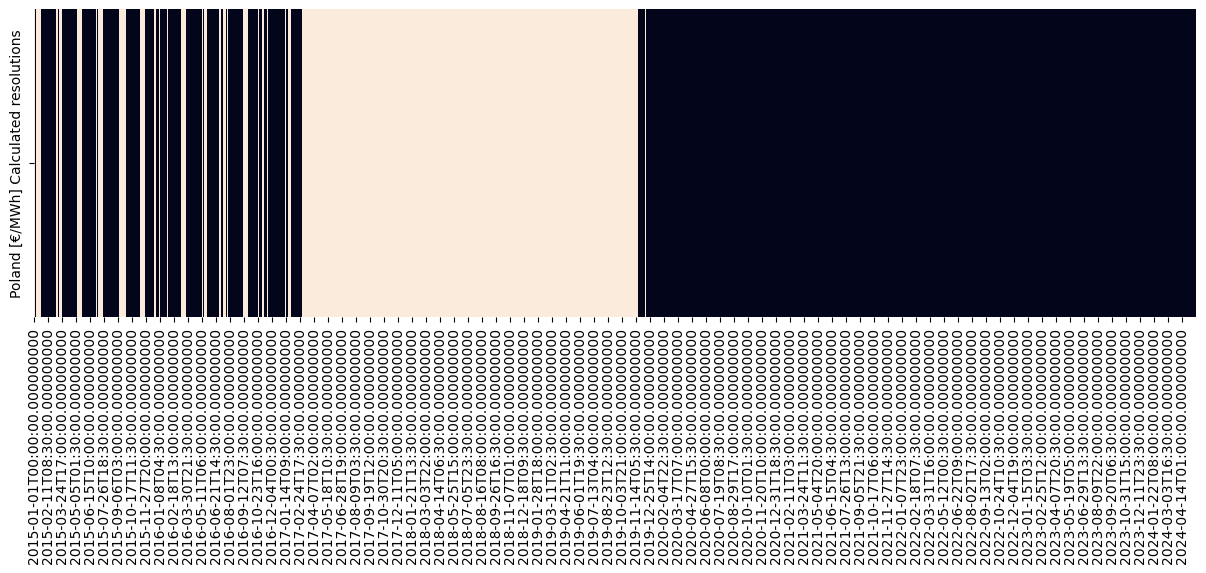

In [68]:
plt.figure(figsize=(15,4))

ax = sns.heatmap(Prices[['Poland [€/MWh] Calculated resolutions']].isna().T,cbar=False)
# ax.set(xticklabels=[])
plt.show()

Export

In [67]:
Prices.to_csv('../data/Prices.csv', index= True)
Cross_Border.to_csv('../data/Cross_Border.csv', index= True)
Consumption.to_csv('../data/Cosumption.csv', index= True)
Generation.to_csv('../data/Generation.csv', index= True)

Target results after data-loading: 

- Impact on the price of nuclear phase-out

- Interpolation model for the gaps in the price of Poland 